In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import seaborn as sns


## samenvoegen van alle data

In [3]:
linac2_headers = pd.read_csv("data/calblocks_update_table_cal_headers.csv", names=["date", "file_name", "empty", "thiing", "thing"])
linac2_items = pd.read_csv("data/calblocks_update_table_cal_items.csv",  names=["item", "category", "thing", "thiing"])
linac2_values = pd.read_csv("data/calblocks_update_table_cal_values.csv", names=["id", "calheaders_id", "item", "part", "value"])

linac2_headers.reset_index(inplace=True)
linac2_headers.set_index("level_0", inplace=True)
linac2_headers['datum'] = linac2_headers['date'].str.replace('/', '-', regex=False)

linac2_headers['date'] = pd.to_datetime(linac2_headers['date'], format='%d/%m/%Y')
linac2_headers["date"] = linac2_headers["date"].astype("str")

linac2_headers.columns = ["linac","date", "file_name", "empty", "thiing", "thing", "datum"]

tempdf = linac2_headers[["linac", "date", "file_name"]].merge(linac2_values[["calheaders_id", "item", "part", "value"]] ,left_on="level_0", right_on="calheaders_id", how="inner").drop(columns="calheaders_id")
merged_df = tempdf.merge(linac2_items[["item", "category"]], on = "item", how="inner")

merged_df["Part&item"] = "I:"+ merged_df["item"].astype(str) + " P:"+ merged_df["part"].astype(str)
merged_df["date"] = pd.to_datetime(merged_df["date"], dayfirst=True, errors="coerce")

merged_df = merged_df.sort_values(["linac", "date"])
merged_df = merged_df[merged_df["linac"] != 7460]

def aanpassen_mlc_leaves(aanpassen, mlc_df):
    for linac in aanpassen["linac"].unique():
        per_l = aanpassen[aanpassen["linac"] == linac]
        dates = per_l["date"].unique().tolist()
        changes = per_l[per_l["date"].isin(dates[:-1])]["value"].values - per_l[per_l["date"].isin(dates[1:])]["value"].values
        changes = pd.DataFrame(index=dates[1:], data=changes, columns=["value"]).reset_index()
        change_dates = changes[changes["value"] < 0]["index"].tolist()
        changes.loc[changes["index"].isin(change_dates), "value"] += 65535
        per_l.iloc[1:,5] = per_l["value"].iloc[1] + changes["value"].cumsum()
        mlc_df.loc[per_l.index] = per_l
    return mlc_df

aanpassen = merged_df[merged_df["Part&item"] == "I:2380 P:185.0"]
aanpassen = aanpassen.sort_values("date")
merged_df = aanpassen_mlc_leaves(aanpassen, merged_df)

aanpassen = merged_df[merged_df["Part&item"] == "I:2460 P:185.0"]
aanpassen = aanpassen.sort_values("date")
merged_df = aanpassen_mlc_leaves(aanpassen, merged_df)

 

C:\Users\Laris\AppData\Local\Temp\ipykernel_18012\2102701078.py:18: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  merged_df["date"] = pd.to_datetime(merged_df["date"], dayfirst=True, errors="coerce")


## storings overzicht
Eerste datum: 2023-09-13

alles er voor en met geen datum wordt verwijderd.


In [4]:

#loading and editingen df
issues = pd.read_csv("data/storing_overzicht.csv")
issues = issues.drop(["Unnamed: 0", "Lev."], axis=1)
issues = issues[issues["Meldtijd"].isna() == False]

issues["Meldtijd"] = pd.to_datetime(issues["Meldtijd"], dayfirst=True, errors="coerce")



# all data from the beginning of the data
# drempel_datum = pd.Timestamp("2023-09-13")
# issues = issues[issues["Meldtijd"] > drempel_datum]


terms = ["XVI", "gantry", "mlc", "lea", "versneller", "mosaiq", "DLG", "tafel", "gun"]
pattern = "|".join([re.escape(term) for term in terms])

# search for terms to determine on what object the issue was
issues["object"] = issues["Storingsinfo"].str.findall(pattern, flags=re.IGNORECASE)
issues["object"] = issues["object"].apply(lambda x: x[0] if x else "")

# filter issues not related to the machine
issues = issues[issues["object"].isin([ "gantry", "mlc", "lea", "versneller", "DLG", "tafel", "filament"])]


## onderhoud overzicht

In [5]:
onderhoud = pd.read_csv("data/onderhoud.csv", header=None, names=["date_done", "name_1", "name_2", "linac"])
onderhoud["date_done"] = pd.to_datetime(onderhoud["date_done"], dayfirst=True, errors="coerce")

drempel_datum = pd.Timestamp("2023-09-13")
onderhoud = onderhoud[onderhoud["date_done"] > drempel_datum]

onderhoud = onderhoud[onderhoud["linac"].isin(["Linac1", "Linac2", "Linac3"])]

linacs = {2325: "Linac1",
              2638: "Linac2",
              2191: "Linac3",
              2983: "Linac4"}
for linac in linacs:
    onderhoud = onderhoud.replace(linacs[linac], linac)

# Functie om volgende woensdag te berekenen
def next_wendsday(datum):
    days_until = (2 - datum.weekday() + 7) % 7
    days_until = 7 if days_until == 0 else days_until
    return datum + pd.Timedelta(days=days_until)

# Nieuwe kolom toevoegen met eerstvolgende woensdag
onderhoud["wendsday"] = onderhoud["date_done"].apply(next_wendsday)

C:\Users\Laris\AppData\Local\Temp\ipykernel_18012\1619582110.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  onderhoud = onderhoud.replace(linacs[linac], linac)


## connect all the different data

In [6]:
from sklearn.preprocessing import OneHotEncoder

# encode
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(onderhoud[["name_1"]])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(["name_1"]))
# remove duplicates
encoded_df["wendsday"] = onderhoud["wendsday"].values
encoded_df["linac"] = onderhoud["linac"].values
onderhoud_df = encoded_df.groupby(["wendsday", "linac"]).max().reset_index()


In [7]:

#onderhoud en linac info combineren
onderhoud_linac = merged_df.merge(onderhoud_df, left_on=["date", "linac"], right_on=["wendsday", "linac"], how="inner").drop(columns="wendsday")

Belangrijk om te kijken naar de frequentie van de aanwezigheid van bestanden.

In [8]:
px.line(onderhoud_linac[onderhoud_linac["linac"] == 2191], x="date", y ="file_name", color="file_name",markers=True, title="per file when its connected to a upkeep")

Een hoop bestanden zijn alleen aangemaakt bij de originele opzet van de linac.

In [9]:
# group and count the amount
counts = onderhoud_linac.groupby(["linac", "file_name", "date"]).size().reset_index(name="aantal")
counts = counts.groupby(["linac", "file_name"]).size().reset_index(name="aantal")

# Filter so you only have the files that are multiple times
files_per_linac = counts[counts["aantal"] > 1]

files_per_linac

,linac,file_name,aantal
0,2191,Be5201,8
3,2191,Be5205,5
9,2191,Be5212,6
11,2191,Be5214,5
12,2191,Be5215,5
...,...,...,...
130,2638,Optics_Dist_Y1_01_To_40,4
131,2638,Optics_Dist_Y2_01_To_40,4
132,2638,Optics_Gen_Cal_Data,4
133,2638,Optics_LP_X_01_To_20,4


Correlatie

c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\Laris\miniconda3\envs\stage\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



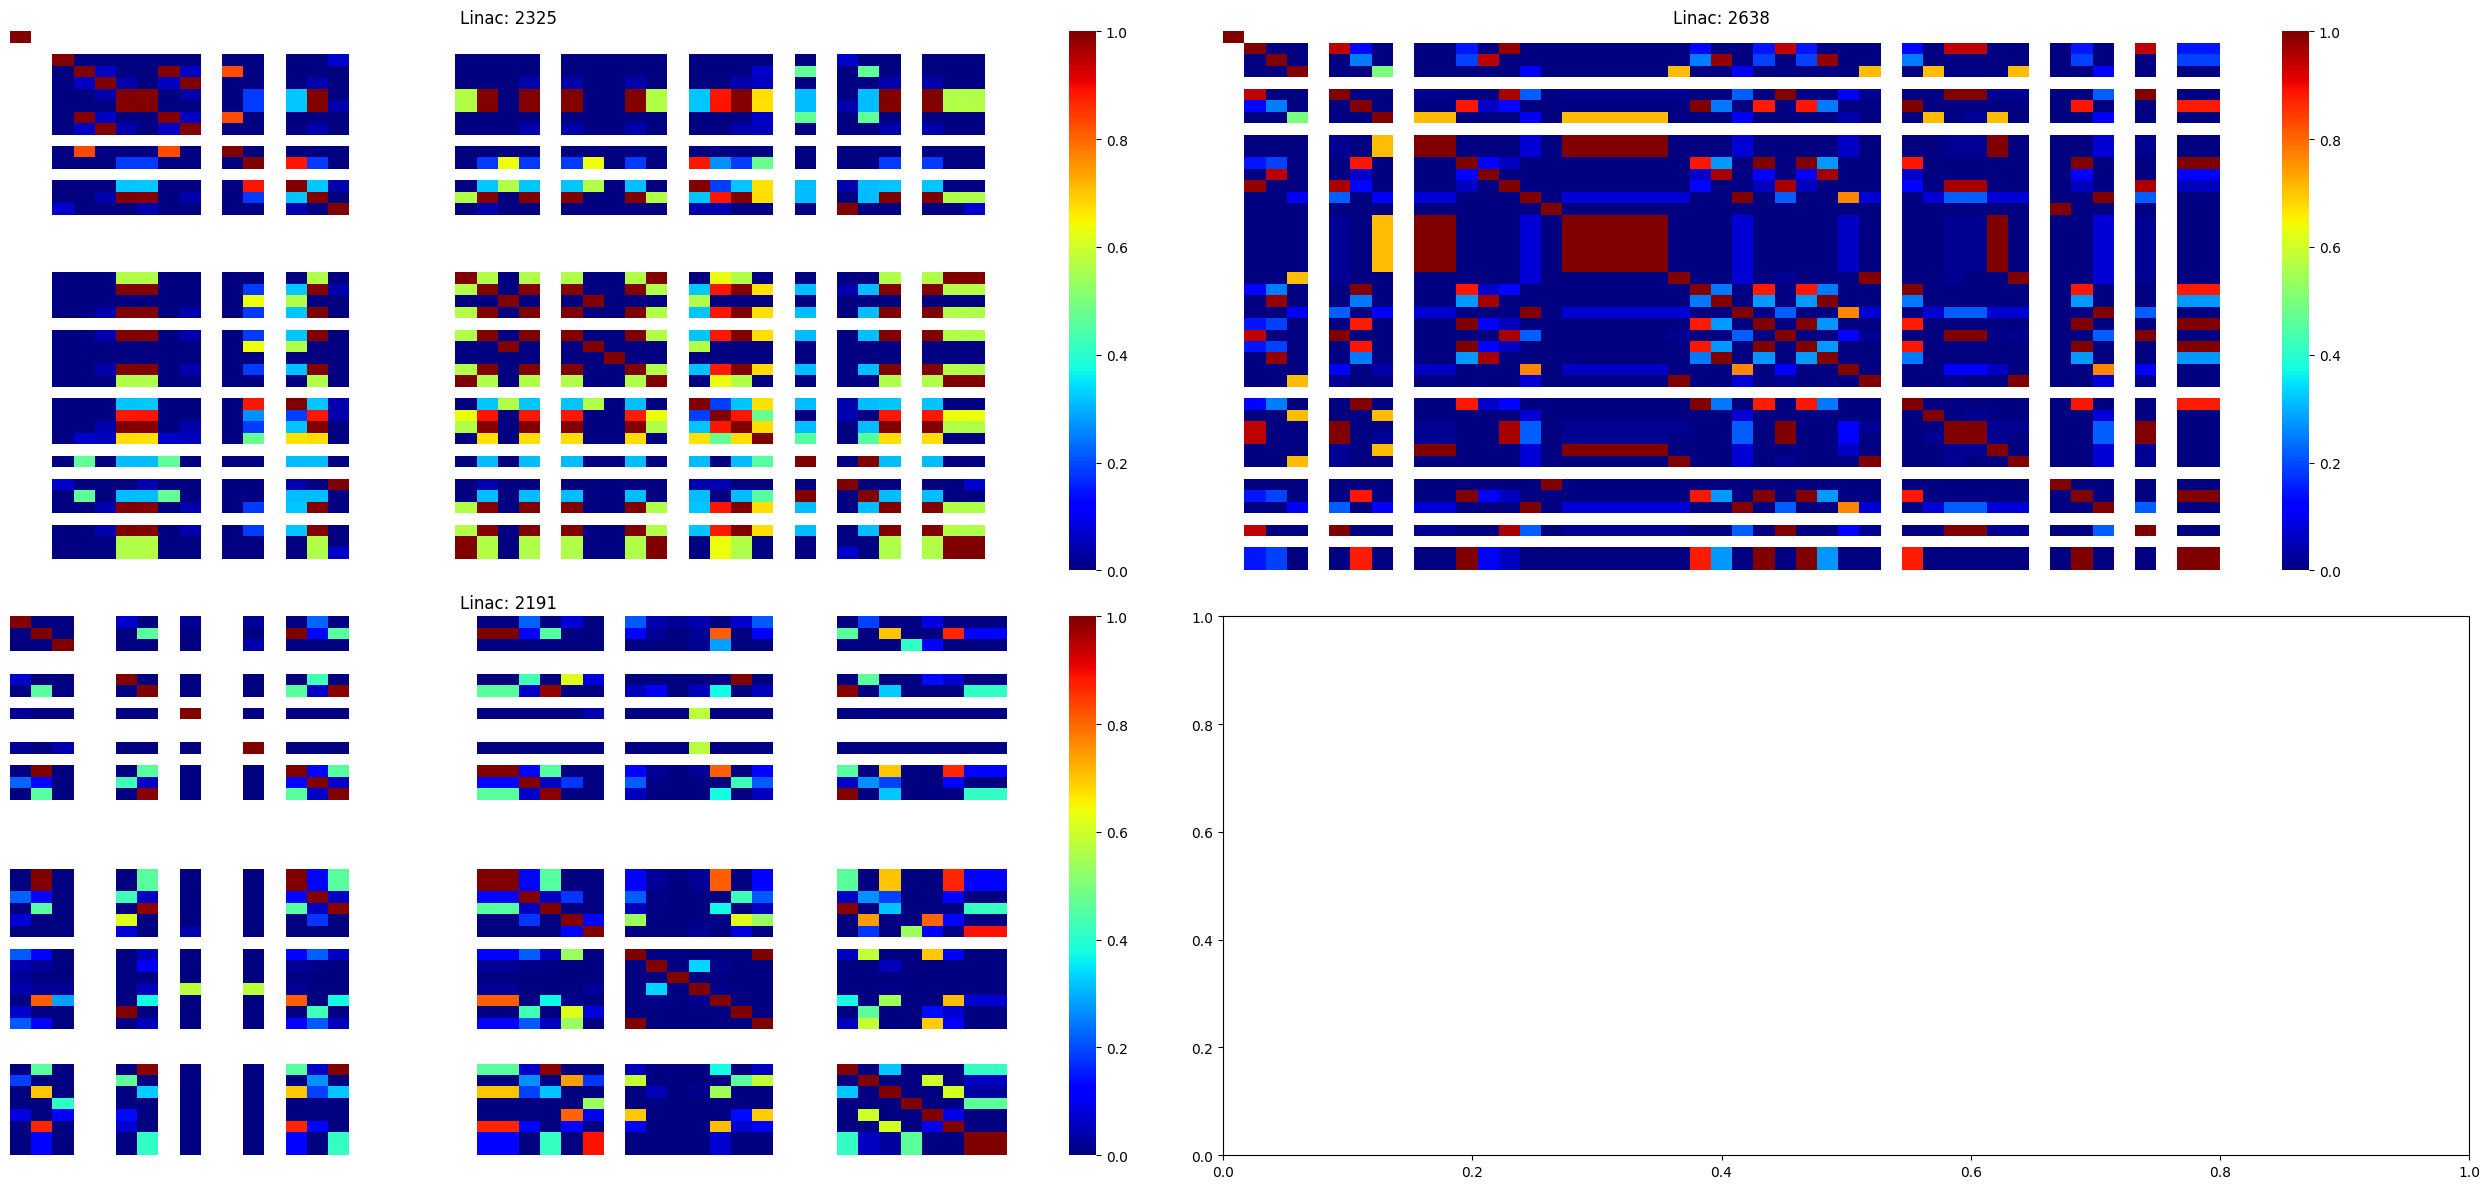

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 12))
linacs = list(set(onderhoud_linac["linac"]))
corr_dfs = []
for num in range(len(linacs)):
    row, col = divmod(num, 2)
    #pick good linac
    tempdf = onderhoud_linac[onderhoud_linac["linac"] == linacs[num]]
    #the file names encode
    encoded_status = encoder.fit_transform(pd.DataFrame(tempdf["file_name"]))
    print(encoded_status)
    #stick together
    for_corr = pd.concat([pd.DataFrame({"file_name": encoded_status}), tempdf.iloc[:,8:]], axis = 1)

    corr = for_corr.corr()
    corr_dfs.append(corr)

    sns.heatmap(corr, cmap="jet", vmin=0.0, vmax=1.0, ax=axes[row, col], yticklabels=False, xticklabels=False )
    axes[row, col].set_title(f"Linac: {linacs[num]}")
    axes[row, col].grid(True)
plt.tight_layout()
plt.show()
    

In [28]:
result = pd.DataFrame()
for corr_df in corr_dfs:
    result = pd.concat([result, corr_df["file_name"]], axis=1)

result

,file_name,file_name,file_name
file_name,1.0,1.0,1.000000
name_1_Accessoires,NaN,NaN,-0.120034
name_1_Agility MLC Calibratie,NaN,NaN,-0.144282
name_1_Ball Bearing,NaN,NaN,NaN
name_1_Bediening,NaN,NaN,NaN
name_1_Botsbeveiliging,NaN,NaN,0.067381
name_1_Bundelas (Draadkruis),NaN,NaN,-0.141668
"name_1_Catphan <a href=c1.php>L1</a>,<a href=c2.php>L2</a>,<a href=c3.php>L3</a>,<a href=c4.php>L4</a>",NaN,NaN,NaN
name_1_Eindstoppen,NaN,NaN,0.022717
name_1_Evenredigheid,NaN,NaN,NaN


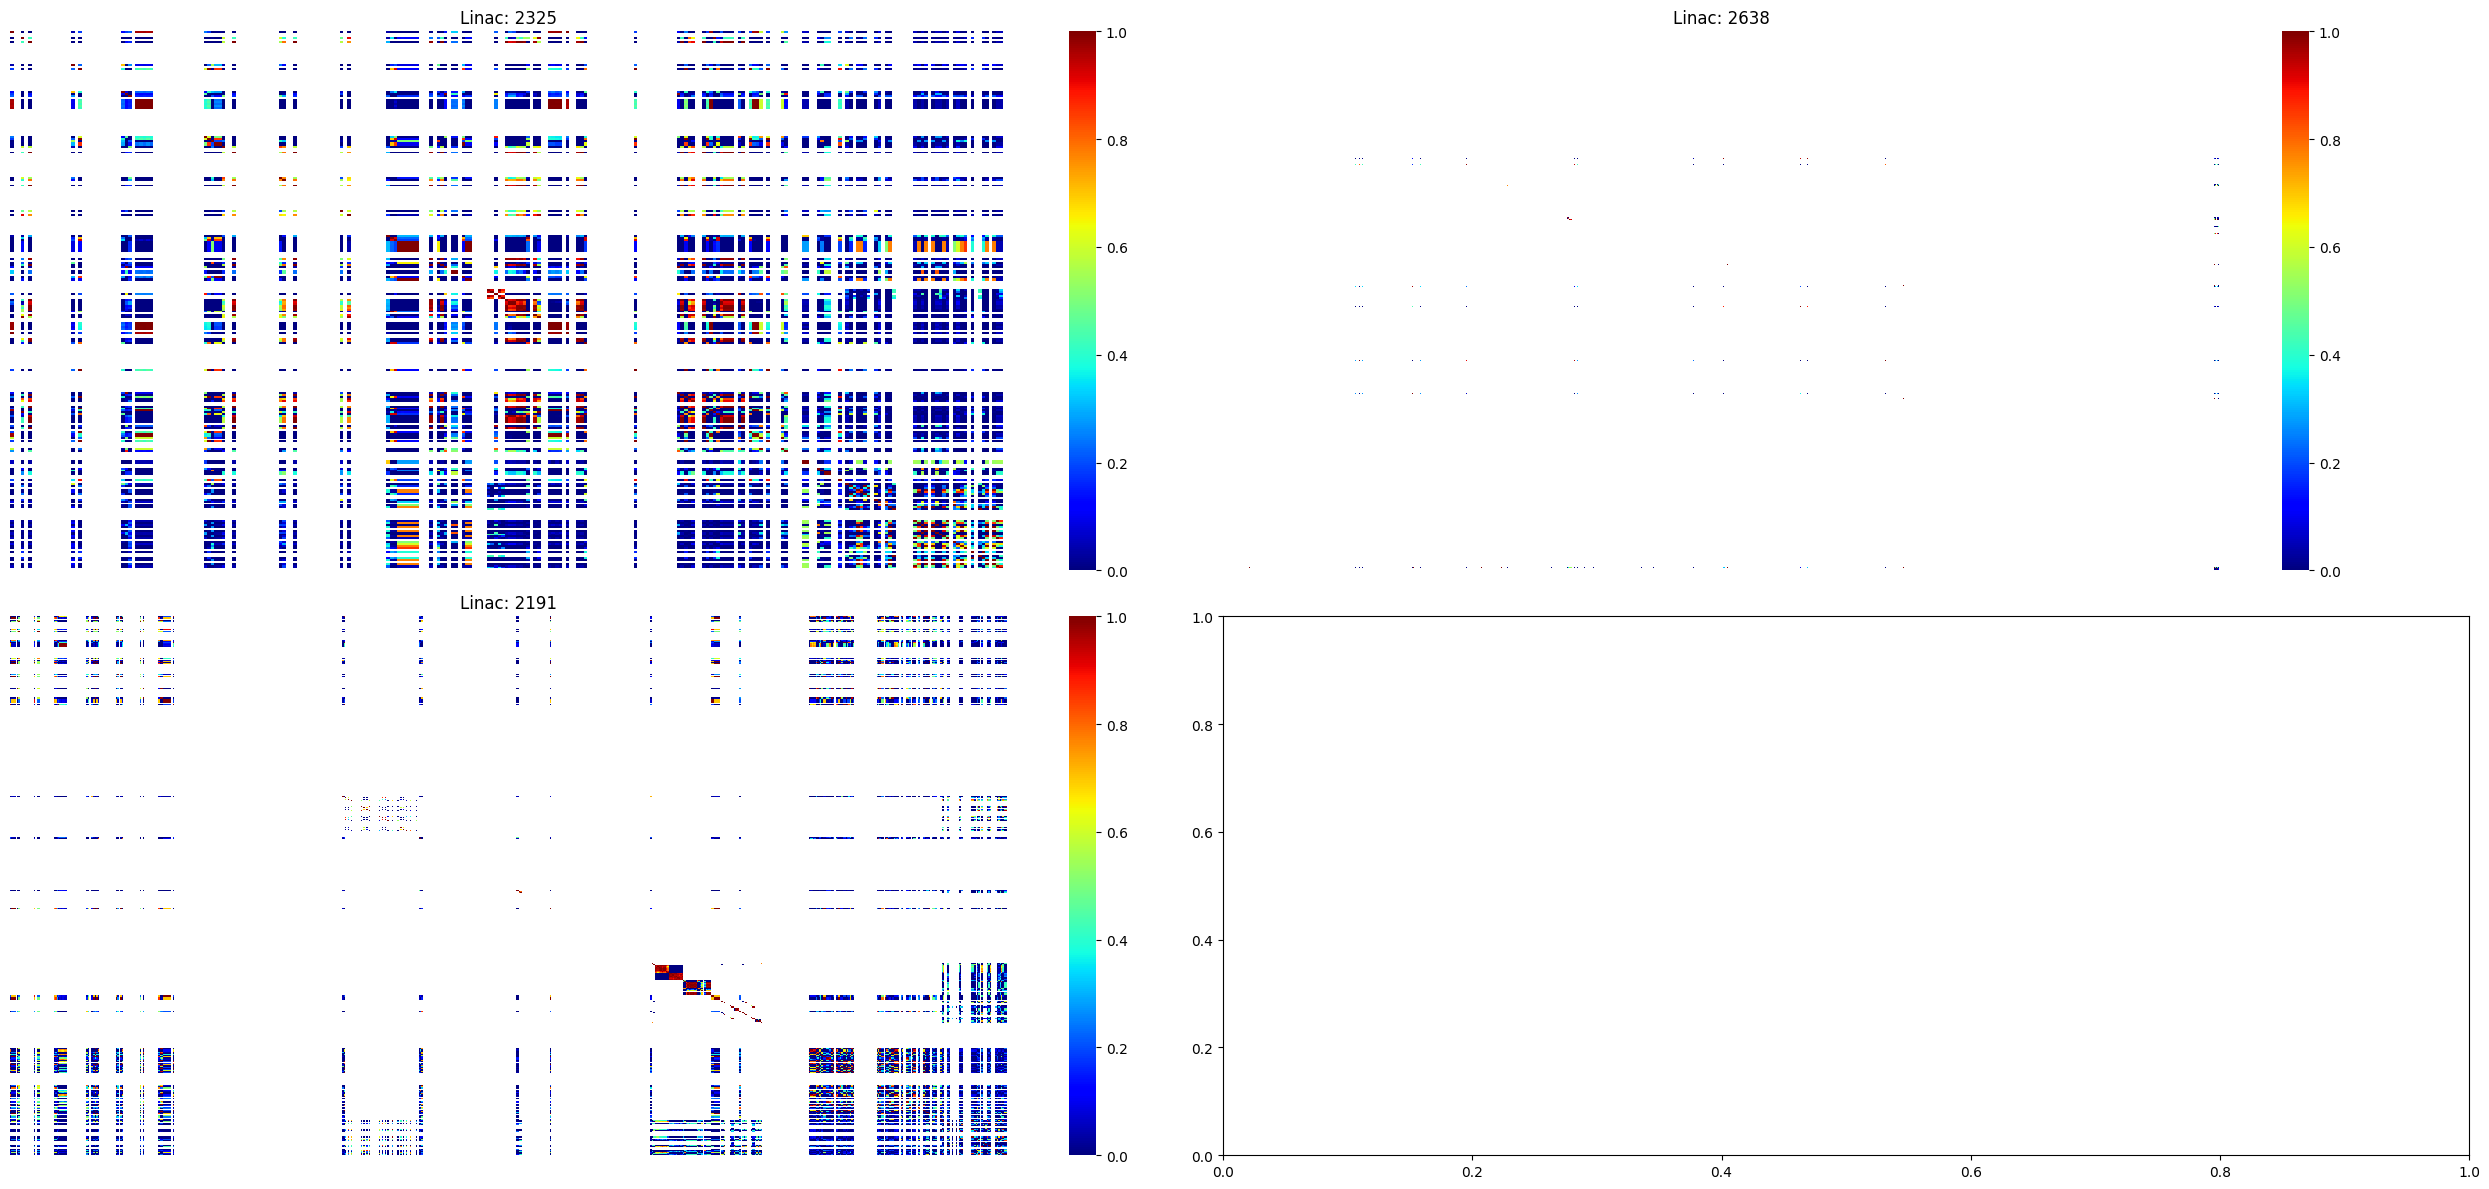

In [11]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 12))
linacs = list(set(onderhoud_linac["linac"]))
corr_dfs = []
for num in range(len(linacs)):
    row, col = divmod(num, 2)
    #get only the filenames that have more than 1 
    files = files_per_linac[files_per_linac["linac"] == linacs[num]]["file_name"].tolist()
    for_cor = onderhoud_linac[onderhoud_linac["file_name"].isin(files)]

    #get good linac
    for_cor = for_cor[for_cor["linac"] == linacs[num]]
    temp_onderhoud_df = onderhoud_df[onderhoud_df["linac"] == linacs[num]]

    #pivot to correlation
    pivoted = for_cor.pivot(index=["date","linac","file_name"], columns=["Part&item"], values="value")
    pivoted = pivoted.merge(temp_onderhoud_df, left_on="date", right_on="wendsday", how="left")


    #correlation
    corr = pivoted.set_index(["wendsday", "linac"]).corr()
    corr_dfs.append(corr)
    sns.heatmap(corr, cmap="jet", vmin=0.0, vmax=1.0, ax=axes[row, col], yticklabels=False, xticklabels=False )
    axes[row, col].set_title(f"Linac: {linacs[num]}")
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()


In [12]:
correlation = corr_dfs[0]
